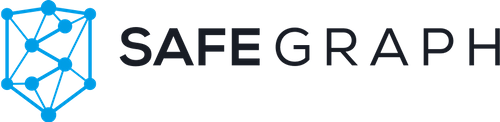

# POI Classification: Part 1

This notebook demonstrates how to classify POI categories based on visit patterns observed in SafeGraph Patterns. In particular, we use Gaussian Naive Bayes, Decision Tree, K-Nearest Neighbors, and Support Vector Machine classifiers to classify train stations, airports, and bus stops.

This notebook is the first in a series of notebooks related classification with Patterns. The next parts of the series will add complexity (and power!) to our analysis.

June 2021

Pranav Thaenraj

---

## Setup

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as pltx
from sklearn.metrics import plot_confusion_matrix

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install pyspark

     |████████████████████████████████| 212.4MB 60kB/s 
     |████████████████████████████████| 204kB 18.6MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=5dcc763bc25efc4e646caed2875bb71498fa276849a349b454c8c193e28f7ed4
  Stored in directory: /root/.cache/pip/wheels/40/1b/2c/30f43be2627857ab80062bef1527c0128f7b4070b6b2d02139
Successfully built pyspark


In [ ]:
import findspark
findspark.init("/content/spark-3.1.2-bin-hadoop2.7")
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

## Data Load

Now we read in the data file. The data used in this project is stored in Google Drive, so we need to authenticate ourselves first.

Check out [the documentation](https://docs.safegraph.com/docs/places-schema#section-patterns) for more info on Patterns data.

This Data is December 2018's Patterns data for Airport services, Train and Metro services, and Bus and other transit services


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()

gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def pd_read_csv_drive(id, drive, dtype=None):
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile('Filename.csv')  
  return(pd.read_csv('Filename.csv',dtype=dtype))

def get_drive_id(filename):
    drive_ids = {'patterns' : '1ReqpLgv50_3mCvZuKLlMdHxwfCPIHmqz'
                 }
    return(drive_ids[filename])

transportation_df = pd_read_csv_drive(get_drive_id('patterns'), drive=drive)
transportation_df.head(3)

,placekey,safegraph_place_id,parent_placekey,parent_safegraph_place_id,location_name,street_address,city,region,postal_code,safegraph_brand_ids,brands,date_range_start,date_range_end,raw_visit_counts,raw_visitor_counts,visits_by_day,poi_cbg,visitor_home_cbgs,visitor_daytime_cbgs,visitor_country_of_origin,distance_from_home,median_dwell,bucketed_dwell_times,related_same_day_brand,related_same_month_brand,popularity_by_hour,popularity_by_day,device_type
0,zzw-222@627-s9k-wkz,sg:2fad0895c4fe4a8f904660121a03c550,NaN,NaN,MTA Bus College Point Depot,12815 28th Ave,Flushing,NY,11354,NaN,NaN,2018-12-01T00:00:00-05:00,2019-01-01T00:00:00-05:00,819,119,"[15,20,35,32,48,33,30,17,20,40,35,49,37,31,15,...",360810907001,"{""360470836002"":4,""360710143024"":4,""3608114090...","{""360810907001"":11,""360810398001"":6,""360810998...","{""US"":112}",11643.0,33.0,"{""<5"":16,""5-10"":169,""11-20"":137,""21-60"":186,""6...","{""Nathan's Famous"":11,""United Rentals"":10,""Arb...","{""Dunkin'"":26,""BP"":22,""McDonald's"":19,""Subway""...","[63,51,40,32,51,66,114,99,136,146,166,163,136,...","{""Monday"":174,""Tuesday"":107,""Wednesday"":158,""T...","{""android"":91,""ios"":29}"
1,zzy-222@8dz-pn7-26k,sg:bfd831d1499b4effb5adcb4718f25769,NaN,NaN,Broken Bow Airport,Broken Bow Airport,Broken Bow,OK,74728,NaN,NaN,2018-12-01T00:00:00-06:00,2019-01-01T00:00:00-06:00,67,27,"[0,0,1,2,1,1,1,4,3,2,1,5,3,3,2,0,4,1,3,11,5,3,...",400890986002,"{""400890986002"":6,""481390602142"":4,""4008909850...","{""400890985002"":4,""050850201011"":4,""4008909860...","{""US"":26}",3850.0,20.0,"{""<5"":0,""5-10"":19,""11-20"":15,""21-60"":15,""61-12...",{},"{""E-Z Mart"":18,""Phillips 66"":18,""Sharpe's"":15,...","[6,7,8,8,7,5,6,8,9,6,8,8,13,11,13,9,8,4,5,4,4,...","{""Monday"":10,""Tuesday"":5,""Wednesday"":10,""Thurs...","{""android"":23,""ios"":4}"
2,zzw-222@5qw-vqg-b49,sg:d305c89f9e0c477e84e692e40be48fe6,NaN,NaN,The Reserve at Bellevue,7301 Ederville Rd,Fort Worth,TX,76112,NaN,NaN,2018-12-01T00:00:00-06:00,2019-01-01T00:00:00-06:00,164,104,"[5,5,2,5,4,4,4,5,3,6,7,5,4,2,7,5,4,3,10,5,11,7...",484391065031,"{""484391065031"":9,""484391052053"":7,""4843910651...","{""481130165201"":4,""484391219042"":4,""4811301630...","{""US"":87}",12406.0,36.5,"{""<5"":9,""5-10"":43,""11-20"":17,""21-60"":30,""61-12...","{""Mobil"":25,""Williams Chicken"":20,""Nissan"":20,...","{""Family Dollar Stores"":19,""Walmart"":17,""Exxon...","[31,26,22,23,23,22,23,23,23,27,25,27,28,30,25,...","{""Monday"":26,""Tuesday"":23,""Wednesday"":23,""Thur...","{""android"":84,""ios"":24}"


## Data Cleansing 

In [ ]:
transportation_df = transportation_df.drop(['parent_safegraph_place_id','placekey','safegraph_place_id','parent_placekey','parent_placekey','safegraph_brand_ids','brands', 'poi_cbg'], axis = 1)
transportation_df.head(3)

,location_name,street_address,city,region,postal_code,date_range_start,date_range_end,raw_visit_counts,raw_visitor_counts,visits_by_day,visitor_home_cbgs,visitor_daytime_cbgs,visitor_country_of_origin,distance_from_home,median_dwell,bucketed_dwell_times,related_same_day_brand,related_same_month_brand,popularity_by_hour,popularity_by_day,device_type
0,MTA Bus College Point Depot,12815 28th Ave,Flushing,NY,11354,2018-12-01T00:00:00-05:00,2019-01-01T00:00:00-05:00,819,119,"[15,20,35,32,48,33,30,17,20,40,35,49,37,31,15,...","{""360470836002"":4,""360710143024"":4,""3608114090...","{""360810907001"":11,""360810398001"":6,""360810998...","{""US"":112}",11643.0,33.0,"{""<5"":16,""5-10"":169,""11-20"":137,""21-60"":186,""6...","{""Nathan's Famous"":11,""United Rentals"":10,""Arb...","{""Dunkin'"":26,""BP"":22,""McDonald's"":19,""Subway""...","[63,51,40,32,51,66,114,99,136,146,166,163,136,...","{""Monday"":174,""Tuesday"":107,""Wednesday"":158,""T...","{""android"":91,""ios"":29}"
1,Broken Bow Airport,Broken Bow Airport,Broken Bow,OK,74728,2018-12-01T00:00:00-06:00,2019-01-01T00:00:00-06:00,67,27,"[0,0,1,2,1,1,1,4,3,2,1,5,3,3,2,0,4,1,3,11,5,3,...","{""400890986002"":6,""481390602142"":4,""4008909850...","{""400890985002"":4,""050850201011"":4,""4008909860...","{""US"":26}",3850.0,20.0,"{""<5"":0,""5-10"":19,""11-20"":15,""21-60"":15,""61-12...",{},"{""E-Z Mart"":18,""Phillips 66"":18,""Sharpe's"":15,...","[6,7,8,8,7,5,6,8,9,6,8,8,13,11,13,9,8,4,5,4,4,...","{""Monday"":10,""Tuesday"":5,""Wednesday"":10,""Thurs...","{""android"":23,""ios"":4}"
2,The Reserve at Bellevue,7301 Ederville Rd,Fort Worth,TX,76112,2018-12-01T00:00:00-06:00,2019-01-01T00:00:00-06:00,164,104,"[5,5,2,5,4,4,4,5,3,6,7,5,4,2,7,5,4,3,10,5,11,7...","{""484391065031"":9,""484391052053"":7,""4843910651...","{""481130165201"":4,""484391219042"":4,""4811301630...","{""US"":87}",12406.0,36.5,"{""<5"":9,""5-10"":43,""11-20"":17,""21-60"":30,""61-12...","{""Mobil"":25,""Williams Chicken"":20,""Nissan"":20,...","{""Family Dollar Stores"":19,""Walmart"":17,""Exxon...","[31,26,22,23,23,22,23,23,23,27,25,27,28,30,25,...","{""Monday"":26,""Tuesday"":23,""Wednesday"":23,""Thur...","{""android"":84,""ios"":24}"


### Labeling Classes


we are attempting to create a Class column to establish the ground truth that is required for supervised learning algorithms such as classification. The data that is used for this project comes with some caveats, especially with the bus stop data. The bus stop NAICS category consists of 'Bus Stop and Other Transit Services'. This category in particular has multiple items such as bus stops as well as truck rentals and yatch services. Thus in order to remove the records that are irrelavent the below fuction was used. 

In [ ]:
#Creation of ground truth Class column (Helper function)
def class_definer(record):
  fixed_record = record.lower()
  if('bus' in fixed_record):
    return 'Bus'
  elif('airport' in fixed_record):
    return 'Airport'
  elif('train' in fixed_record):
    return 'Train'
  elif('metro' in fixed_record):
    return 'Train'
  elif('transport' in fixed_record):
    return 'Bus'
  elif('amtrak' in fixed_record):
    return 'Train'
  elif('bart' in fixed_record):
    return 'Train'
  elif('cta' in fixed_record):
    return 'Train'
  elif('mta' in fixed_record):
    return 'Train'
  elif('transit' in fixed_record):
    return 'Bus'
  elif('mbta' in fixed_record):
    return 'Train'
  elif('station' in fixed_record):
    return 'Train'
  elif('railway' in fixed_record):
    return 'Train'
  else:
    return 'Unknown'

In [ ]:
#Class_definer implementation
transportation_df['Class'] = transportation_df['location_name'].transform(lambda x: class_definer(x))
transportation_df.head(3)

,location_name,street_address,city,region,postal_code,date_range_start,date_range_end,raw_visit_counts,raw_visitor_counts,visits_by_day,visitor_home_cbgs,visitor_daytime_cbgs,visitor_country_of_origin,distance_from_home,median_dwell,bucketed_dwell_times,related_same_day_brand,related_same_month_brand,popularity_by_hour,popularity_by_day,device_type,Class
0,MTA Bus College Point Depot,12815 28th Ave,Flushing,NY,11354,2018-12-01T00:00:00-05:00,2019-01-01T00:00:00-05:00,819,119,"[15,20,35,32,48,33,30,17,20,40,35,49,37,31,15,...","{""360470836002"":4,""360710143024"":4,""3608114090...","{""360810907001"":11,""360810398001"":6,""360810998...","{""US"":112}",11643.0,33.0,"{""<5"":16,""5-10"":169,""11-20"":137,""21-60"":186,""6...","{""Nathan's Famous"":11,""United Rentals"":10,""Arb...","{""Dunkin'"":26,""BP"":22,""McDonald's"":19,""Subway""...","[63,51,40,32,51,66,114,99,136,146,166,163,136,...","{""Monday"":174,""Tuesday"":107,""Wednesday"":158,""T...","{""android"":91,""ios"":29}",Bus
1,Broken Bow Airport,Broken Bow Airport,Broken Bow,OK,74728,2018-12-01T00:00:00-06:00,2019-01-01T00:00:00-06:00,67,27,"[0,0,1,2,1,1,1,4,3,2,1,5,3,3,2,0,4,1,3,11,5,3,...","{""400890986002"":6,""481390602142"":4,""4008909850...","{""400890985002"":4,""050850201011"":4,""4008909860...","{""US"":26}",3850.0,20.0,"{""<5"":0,""5-10"":19,""11-20"":15,""21-60"":15,""61-12...",{},"{""E-Z Mart"":18,""Phillips 66"":18,""Sharpe's"":15,...","[6,7,8,8,7,5,6,8,9,6,8,8,13,11,13,9,8,4,5,4,4,...","{""Monday"":10,""Tuesday"":5,""Wednesday"":10,""Thurs...","{""android"":23,""ios"":4}",Airport
2,The Reserve at Bellevue,7301 Ederville Rd,Fort Worth,TX,76112,2018-12-01T00:00:00-06:00,2019-01-01T00:00:00-06:00,164,104,"[5,5,2,5,4,4,4,5,3,6,7,5,4,2,7,5,4,3,10,5,11,7...","{""484391065031"":9,""484391052053"":7,""4843910651...","{""481130165201"":4,""484391219042"":4,""4811301630...","{""US"":87}",12406.0,36.5,"{""<5"":9,""5-10"":43,""11-20"":17,""21-60"":30,""61-12...","{""Mobil"":25,""Williams Chicken"":20,""Nissan"":20,...","{""Family Dollar Stores"":19,""Walmart"":17,""Exxon...","[31,26,22,23,23,22,23,23,23,27,25,27,28,30,25,...","{""Monday"":26,""Tuesday"":23,""Wednesday"":23,""Thur...","{""android"":84,""ios"":24}",Unknown


In [ ]:
transportation_df['Class'].value_counts()

Airport    3824
Unknown    1482
Train      1478
Bus         667
Name: Class, dtype: int64

In [ ]:
#What are the columns marked as Unknown?
transportation_df[transportation_df['Class'] == 'Unknown'].head(3)

,location_name,street_address,city,region,postal_code,date_range_start,date_range_end,raw_visit_counts,raw_visitor_counts,visits_by_day,visitor_home_cbgs,visitor_daytime_cbgs,visitor_country_of_origin,distance_from_home,median_dwell,bucketed_dwell_times,related_same_day_brand,related_same_month_brand,popularity_by_hour,popularity_by_day,device_type,Class
2,The Reserve at Bellevue,7301 Ederville Rd,Fort Worth,TX,76112,2018-12-01T00:00:00-06:00,2019-01-01T00:00:00-06:00,164,104,"[5,5,2,5,4,4,4,5,3,6,7,5,4,2,7,5,4,3,10,5,11,7...","{""484391065031"":9,""484391052053"":7,""4843910651...","{""481130165201"":4,""484391219042"":4,""4811301630...","{""US"":87}",12406.0,36.5,"{""<5"":9,""5-10"":43,""11-20"":17,""21-60"":30,""61-12...","{""Mobil"":25,""Williams Chicken"":20,""Nissan"":20,...","{""Family Dollar Stores"":19,""Walmart"":17,""Exxon...","[31,26,22,23,23,22,23,23,23,27,25,27,28,30,25,...","{""Monday"":26,""Tuesday"":23,""Wednesday"":23,""Thur...","{""android"":84,""ios"":24}",Unknown
42,G & B Enterprises,1002 N Washington St,Junction City,KS,66441,2018-12-01T00:00:00-06:00,2019-01-01T00:00:00-06:00,1,1,"[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0...","{""200610001003"":4}",{},{},NaN,939.0,"{""<5"":0,""5-10"":0,""11-20"":0,""21-60"":0,""61-120"":...",{},"{""IHOP"":98}","[1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1]","{""Monday"":0,""Tuesday"":0,""Wednesday"":0,""Thursda...","{""android"":4,""ios"":0}",Unknown
44,Hanging Lake Express,110 Wulfson Rd,Glenwood Springs,CO,81601,2018-12-01T00:00:00-07:00,2019-01-01T00:00:00-07:00,22,19,"[1,1,0,1,0,0,0,0,0,2,1,0,0,1,1,0,0,1,2,1,0,1,1...","{""080459519023"":4,""040190036004"":4,""0804595180...","{""040190036005"":4,""080010090023"":4,""0804595190...","{""US"":19}",132655.0,18.0,"{""<5"":1,""5-10"":8,""11-20"":4,""21-60"":3,""61-120"":...","{""City Market"":100,""Safeway Fuel Station"":50}","{""Starbucks"":45,""Shell Oil"":41,""Walmart"":40,""L...","[0,0,0,0,0,0,1,2,0,1,4,4,5,6,3,1,6,4,1,1,0,0,0,0]","{""Monday"":4,""Tuesday"":3,""Wednesday"":3,""Thursda...","{""android"":7,""ios"":11}",Unknown


These unknown columns are representative of the Motor Transit records that come with the Bus data in the patterns data. We can drop these records becuase they are not exactly alligned with the notions of bus services - more tending towards ideas wuch as Truck services, and Yatch rentals and other transit services that are away from the concept of a bus service

In [ ]:
transportation_df = transportation_df[transportation_df['Class'] != 'Unknown'].dropna()
transportation_df.head(3)

,location_name,street_address,city,region,postal_code,date_range_start,date_range_end,raw_visit_counts,raw_visitor_counts,visits_by_day,visitor_home_cbgs,visitor_daytime_cbgs,visitor_country_of_origin,distance_from_home,median_dwell,bucketed_dwell_times,related_same_day_brand,related_same_month_brand,popularity_by_hour,popularity_by_day,device_type,Class
0,MTA Bus College Point Depot,12815 28th Ave,Flushing,NY,11354,2018-12-01T00:00:00-05:00,2019-01-01T00:00:00-05:00,819,119,"[15,20,35,32,48,33,30,17,20,40,35,49,37,31,15,...","{""360470836002"":4,""360710143024"":4,""3608114090...","{""360810907001"":11,""360810398001"":6,""360810998...","{""US"":112}",11643.0,33.0,"{""<5"":16,""5-10"":169,""11-20"":137,""21-60"":186,""6...","{""Nathan's Famous"":11,""United Rentals"":10,""Arb...","{""Dunkin'"":26,""BP"":22,""McDonald's"":19,""Subway""...","[63,51,40,32,51,66,114,99,136,146,166,163,136,...","{""Monday"":174,""Tuesday"":107,""Wednesday"":158,""T...","{""android"":91,""ios"":29}",Bus
1,Broken Bow Airport,Broken Bow Airport,Broken Bow,OK,74728,2018-12-01T00:00:00-06:00,2019-01-01T00:00:00-06:00,67,27,"[0,0,1,2,1,1,1,4,3,2,1,5,3,3,2,0,4,1,3,11,5,3,...","{""400890986002"":6,""481390602142"":4,""4008909850...","{""400890985002"":4,""050850201011"":4,""4008909860...","{""US"":26}",3850.0,20.0,"{""<5"":0,""5-10"":19,""11-20"":15,""21-60"":15,""61-12...",{},"{""E-Z Mart"":18,""Phillips 66"":18,""Sharpe's"":15,...","[6,7,8,8,7,5,6,8,9,6,8,8,13,11,13,9,8,4,5,4,4,...","{""Monday"":10,""Tuesday"":5,""Wednesday"":10,""Thurs...","{""android"":23,""ios"":4}",Airport
3,Edgar County Airport,Edgar County Airport,Paris,IL,61944,2018-12-01T00:00:00-06:00,2019-01-01T00:00:00-06:00,41,10,"[0,0,2,1,2,1,1,0,0,3,2,0,2,2,0,0,4,2,1,2,4,2,0...","{""170450704004"":4}","{""170450704004"":4,""170450701002"":4}","{""US"":6}",9462.0,42.0,"{""<5"":0,""5-10"":14,""11-20"":1,""21-60"":13,""61-120...",{},"{""Walmart"":62,""Casey's General Stores"":49,""Jo-...","[0,0,0,0,0,0,0,9,7,7,9,11,7,11,14,7,3,1,0,0,0,...","{""Monday"":9,""Tuesday"":5,""Wednesday"":5,""Thursda...","{""android"":6,""ios"":7}",Airport


### Horizontal Expansion of JSON Columns

The data is prepared in all needed ways except for the horizontal expansion of the JSON columns. This can be done easily through the use of pyspark.

In [ ]:
#Conversion to Spark_df
transportation_df = spark.createDataFrame(transportation_df)
transportation_df.show(2)

+--------------------+------------------+----------+------+-----------+--------------------+--------------------+----------------+------------------+--------------------+--------------------+--------------------+-------------------------+------------------+------------+--------------------+----------------------+------------------------+--------------------+--------------------+--------------------+-------+
|       location_name|    street_address|      city|region|postal_code|    date_range_start|      date_range_end|raw_visit_counts|raw_visitor_counts|       visits_by_day|   visitor_home_cbgs|visitor_daytime_cbgs|visitor_country_of_origin|distance_from_home|median_dwell|bucketed_dwell_times|related_same_day_brand|related_same_month_brand|  popularity_by_hour|   popularity_by_day|         device_type|  Class|
+--------------------+------------------+----------+------+-----------+--------------------+--------------------+----------------+------------------+--------------------+--------

In [ ]:
#Horizontal Explosion of JSON columns using Pyspark
from pyspark.sql.functions import from_json,expr
from pyspark.sql.types import StructType, StructField, StringType, ArrayType, IntegerType

day_schema = StructType(
    [
      StructField('Monday', IntegerType(),True),
      StructField('Tuesday', IntegerType(),True),
      StructField('Wednesday', IntegerType(),True),
      StructField('Thursday', IntegerType(),True),
      StructField('Friday', IntegerType(),True),
      StructField('Saturday', IntegerType(),True),
      StructField('Sunday', IntegerType(),True)
    ]
)
device_schema = StructType(
    [
      StructField('android', IntegerType(),True),
      StructField('ios', IntegerType(),True)
    ]
)
bucketedDT_schema = StructType(
    [
     StructField('<5',IntegerType(),True),
     StructField('5-10',IntegerType(),True),
     StructField('11-20',IntegerType(),True),
     StructField('21-60',IntegerType(),True),
     StructField('61-120',IntegerType(),True),
     StructField('121-240',IntegerType(),True),
     StructField('>240',IntegerType(),True)
    ]
)
transportation_df = transportation_df.withColumn('popularity_by_day', from_json('popularity_by_day', day_schema)).withColumn('device_type', from_json('device_type', device_schema)).withColumn('bucketed_dwell_times',from_json('bucketed_dwell_times',bucketedDT_schema)).select('location_name','raw_visit_counts','raw_visitor_counts','visits_by_day',
          'distance_from_home','median_dwell',
          'bucketed_dwell_times.*','popularity_by_hour','popularity_by_day.*',
          'device_type.*','Class')
transportation_df = transportation_df.toPandas()
transportation_df.head(3)

,location_name,raw_visit_counts,raw_visitor_counts,visits_by_day,distance_from_home,median_dwell,<5,5-10,11-20,21-60,61-120,121-240,>240,popularity_by_hour,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,android,ios,Class
0,MTA Bus College Point Depot,819,119,"[15,20,35,32,48,33,30,17,20,40,35,49,37,31,15,...",11643.0,33.0,16,169,137,186,111,97,103,"[63,51,40,32,51,66,114,99,136,146,166,163,136,...",174,107,158,119,107,72,82,91,29,Bus
1,Broken Bow Airport,67,27,"[0,0,1,2,1,1,1,4,3,2,1,5,3,3,2,0,4,1,3,11,5,3,...",3850.0,20.0,0,19,15,15,6,4,8,"[6,7,8,8,7,5,6,8,9,6,8,8,13,11,13,9,8,4,5,4,4,...",10,5,10,18,10,9,5,23,4,Airport
2,Edgar County Airport,41,10,"[0,0,2,1,2,1,1,0,0,3,2,0,2,2,0,0,4,2,1,2,4,2,0...",9462.0,42.0,0,14,1,13,7,3,3,"[0,0,0,0,0,0,0,9,7,7,9,11,7,11,14,7,3,1,0,0,0,...",9,5,5,6,8,2,6,6,7,Airport


Expansion of the array columns such as visits and popularity

In [ ]:

# transportation_df['visits_by_day'] = transportation_df['visits_by_day'].transform(lambda x: literal_eval(x))
# visits = ['visits_' + str(i) for i in range(1,32)]
# transportation_df[visits] = pd.DataFrame(transportation_df.visits_by_day.to_list(), index=transportation_df.index)
# transportation_df = transportation_df.drop(['visits_by_day'], axis = 1)
# transportation_df = transportation_df.reindex()

from ast import literal_eval

transportation_df['popularity_by_hour'] = transportation_df['popularity_by_hour'].transform(lambda x: literal_eval(x))
pops = ['popularity_' + str(i) for i in range(1,25)]
transportation_df[pops] = pd.DataFrame(transportation_df.popularity_by_hour.to_list(), index=transportation_df.index)
transportation_df = transportation_df.drop(['popularity_by_hour'], axis = 1)
transportation_df = transportation_df.reindex()

transportation_df.drop('visits_by_day', axis=1, inplace=True)

transportation_df.head(3)

,location_name,raw_visit_counts,raw_visitor_counts,distance_from_home,median_dwell,<5,5-10,11-20,21-60,61-120,121-240,>240,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,android,ios,Class,popularity_1,popularity_2,popularity_3,popularity_4,popularity_5,popularity_6,popularity_7,popularity_8,popularity_9,popularity_10,popularity_11,popularity_12,popularity_13,popularity_14,popularity_15,popularity_16,popularity_17,popularity_18,popularity_19,popularity_20,popularity_21,popularity_22,popularity_23,popularity_24
0,MTA Bus College Point Depot,819,119,11643.0,33.0,16,169,137,186,111,97,103,174,107,158,119,107,72,82,91,29,Bus,63,51,40,32,51,66,114,99,136,146,166,163,136,160,121,104,91,41,76,42,42,40,44,51
1,Broken Bow Airport,67,27,3850.0,20.0,0,19,15,15,6,4,8,10,5,10,18,10,9,5,23,4,Airport,6,7,8,8,7,5,6,8,9,6,8,8,13,11,13,9,8,4,5,4,4,8,7,6
2,Edgar County Airport,41,10,9462.0,42.0,0,14,1,13,7,3,3,9,5,5,6,8,2,6,6,7,Airport,0,0,0,0,0,0,0,9,7,7,9,11,7,11,14,7,3,1,0,0,0,0,0,0


Add the class label to our data

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(transportation_df['Class'])
transportation_df['Class'] = le.transform(transportation_df['Class'])
transportation_df.head(3)

,location_name,raw_visit_counts,raw_visitor_counts,distance_from_home,median_dwell,<5,5-10,11-20,21-60,61-120,121-240,>240,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,android,ios,Class,popularity_1,popularity_2,popularity_3,popularity_4,popularity_5,popularity_6,popularity_7,popularity_8,popularity_9,popularity_10,popularity_11,popularity_12,popularity_13,popularity_14,popularity_15,popularity_16,popularity_17,popularity_18,popularity_19,popularity_20,popularity_21,popularity_22,popularity_23,popularity_24
0,MTA Bus College Point Depot,819,119,11643.0,33.0,16,169,137,186,111,97,103,174,107,158,119,107,72,82,91,29,1,63,51,40,32,51,66,114,99,136,146,166,163,136,160,121,104,91,41,76,42,42,40,44,51
1,Broken Bow Airport,67,27,3850.0,20.0,0,19,15,15,6,4,8,10,5,10,18,10,9,5,23,4,0,6,7,8,8,7,5,6,8,9,6,8,8,13,11,13,9,8,4,5,4,4,8,7,6
2,Edgar County Airport,41,10,9462.0,42.0,0,14,1,13,7,3,3,9,5,5,6,8,2,6,6,7,0,0,0,0,0,0,0,0,9,7,7,9,11,7,11,14,7,3,1,0,0,0,0,0,0


## Classification Algorithims

Since there are 3 unique classes, we need to use a multiclass classifier. We will try Gaussian Naive Bayes, Decision Trees, K-Nearest Neighbors, and the SVM Classifier. First, we must split our data into test and train sets.

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
x_cols = []
for item in list(transportation_df.columns):
  if(item != 'Class' and item != 'location_name'):
    x_cols.append(item)
X = transportation_df[x_cols]
y = transportation_df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
X.head(3)

,raw_visit_counts,raw_visitor_counts,distance_from_home,median_dwell,<5,5-10,11-20,21-60,61-120,121-240,>240,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,android,ios,popularity_1,popularity_2,popularity_3,popularity_4,popularity_5,popularity_6,popularity_7,popularity_8,popularity_9,popularity_10,popularity_11,popularity_12,popularity_13,popularity_14,popularity_15,popularity_16,popularity_17,popularity_18,popularity_19,popularity_20,popularity_21,popularity_22,popularity_23,popularity_24
0,819,119,11643.0,33.0,16,169,137,186,111,97,103,174,107,158,119,107,72,82,91,29,63,51,40,32,51,66,114,99,136,146,166,163,136,160,121,104,91,41,76,42,42,40,44,51
1,67,27,3850.0,20.0,0,19,15,15,6,4,8,10,5,10,18,10,9,5,23,4,6,7,8,8,7,5,6,8,9,6,8,8,13,11,13,9,8,4,5,4,4,8,7,6
2,41,10,9462.0,42.0,0,14,1,13,7,3,3,9,5,5,6,8,2,6,6,7,0,0,0,0,0,0,0,9,7,7,9,11,7,11,14,7,3,1,0,0,0,0,0,0


In [ ]:
y.head()

0    1
1    0
2    0
3    2
4    0
Name: Class, dtype: int64

### Gaussian Naive Bayes Classifier

Here is a little background regarding the functionality of the Naive Bayes Classifier: [Gaussian Naive Bayes](https://towardsdatascience.com/naive-bayes-classifier-81d512f50a7c)

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB().fit(X_train, y_train)
gnb_predictions = gnb.predict(X_test)
gnb_predictions

array([2, 2, 2, ..., 2, 2, 2])

In [ ]:
accuracy = gnb.score(X_test, y_test)
print(accuracy)


0.26552287581699346


In [ ]:
confusion_matrix(y_test, gnb_predictions)

array([[ 49, 142, 639],
       [  1,   1, 108],
       [  0,   9, 275]])

Visualize the confusion matrix below. In our case, yellow indicates high incidence and purple indicates low incidence. Our "correct" predictions are shown in the diagonal from the top-left corner to the bottom-right corner.

Ideally, we would see yellow in the diagonal and purple everywhere else.

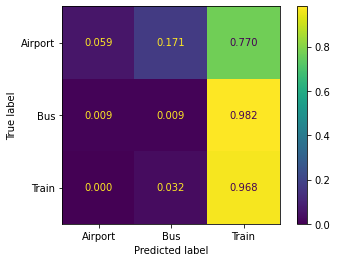

In [ ]:
plot_confusion_matrix(gnb, X_test, y_test, normalize='true', values_format = '.3f', display_labels=['Airport','Bus','Train'])

This shows that the Guassian Naive Bayes does not do too well with classifying this particular dataset. This could be attributed to the classifier considering each of the features indiviudally without the considerations of their correlations (thus the classifier being 'naive'). This would make it difficult for the classifier to do well when features have high correlation coefficients such as this particular dataset, where many of the features are exploded from one column and are directly correlated with one another.

The accuracy of the model comes out to about 26%. The heatmap shows that a lot of values that are actually an airport are misclassified as a train station. The same can be said of true bus stations being misclassified as train stations. This shows that the majority of the records are actually classified as a train station.

### Decision Tree Classifier

Here is a little background regarding the functionality of the Decision Tree classifier: [Decision Tree](https://medium.com/swlh/decision-tree-classification-de64fc4d5aac)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtree_model = DecisionTreeClassifier(max_depth = 3).fit(X_train, y_train)
dtree_predictions = dtree_model.predict(X_test)

In [ ]:
dtree_model.score(X_test,y_test)

0.75

In [ ]:
confusion_matrix(y_test, dtree_predictions)

array([[761,   0,  69],
       [ 83,   0,  27],
       [127,   0, 157]])

Visualize the confusion matrix below. In our case, yellow indicates high incidence and purple indicates low incidence. Our "correct" predictions are shown in the diagonal from the top-left corner to the bottom-right corner.

Ideally, we would see yellow in the diagonal and purple everywhere else.

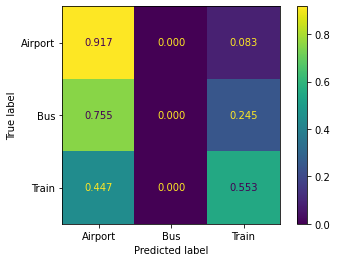

In [ ]:
plot_confusion_matrix(dtree_model, X_test, y_test, normalize='true', values_format = '.3f', display_labels=['Airport','Bus','Train'])

From this we can see that the Decision Tree model performs much better than the Naive Bayes, with an accuracy of 75%. Considering that this is a multiclass classifier, this accuracy is fairly decent.

The classifier seems to do a very good job at correctly classifying Airports, doing so at an accuracy rate of ~91.7% indicating that a model that takes into account the correlations between the various features of the data can perform very well in classifying the airports of this data correctly. The same cannot be said of the bus stop records, for none of the true Bus stop records were classified as bus stops. The Train station data seems to perform slightly better, classifying ~55.3% of true Train station data as Train stations. An interesting observation to make regarding this particular model's predictions is that none of the records are classified as a Bus stop---either correctly or incorrectly. This could be attributed to the smaller number of bus station records in comparison to the Train station and Airport records and the nature of the Decision Tree algorithim. The Decision Tree algorithim performs extremely well when using very balanced data, but doesn't perform as well on imbalanced data as in the case we have here.

### K-Nearest Neighbors Classifier

Here is a little background regarding the functionality of the KNN classifier: [KNN](https://www.analyticsvidhya.com/blog/2018/03/introduction-k-neighbours-algorithm-clustering/)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 22).fit(X_train, y_train)

In [ ]:
accuracy = knn.score(X_test, y_test)
accuracy

0.6797385620915033

In [ ]:
knn_predictions = knn.predict(X_test) 
confusion_matrix(y_test, knn_predictions)

array([[778,  10,  42],
       [ 93,   3,  14],
       [226,   7,  51]])

Visualize the confusion matrix below. In our case, yellow indicates high incidence and purple indicates low incidence. Our "correct" predictions are shown in the diagonal from the top-left corner to the bottom-right corner.

Ideally, we would see yellow in the diagonal and purple everywhere else.

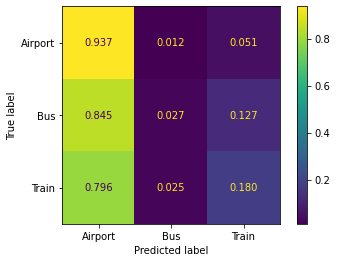

In [ ]:
plot_confusion_matrix(knn, X_test, y_test, normalize='true', values_format = '.3f', display_labels=['Airport','Bus','Train'])

This classifier has an accuracy of about ~ 68.0%. The classifier does extremely well with classifying the Airport records properly, having an accuracy of ~93.7%. The number of correctly classified bus stops is no longer 0, but its still very low, this can again be attributed to the imbalanced data. This classifier does slightly worse with train classification that the decision tree model, predicting only ~18.3% of the true train stations as train stations.   

### Support Vector Machines Classifiers

The training step for our SVM classifier takes about 2 hours. For that reason, we've commented all the code out. You are welcome to remove the comments and build the model---the code is all there!

Here is a little background regarding Support Vector Machines and their functionality: [SVM](https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47)

In [ ]:
# from sklearn.svm import SVC
# svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train)
# svm_predictions = svm_model_linear.predict(X_test)

In [ ]:
# accuracy = svm_model_linear.score(X_test, y_test)
# accuracy

In [ ]:
# confusion_matrix(y_test, svm_predictions)

Visualize the confusion matrix below. In our case, yellow indicates high incidence and purple indicates low incidence. Our "correct" predictions are shown in the diagonal from the top-left corner to the bottom-right corner.

Ideally, we would see yellow in the diagonal and purple everywhere else.

In [ ]:
# plot_confusion_matrix(svm_model_linear, X_test, y_test, normalize='true', values_format = '.3f', display_labels=['Airport','Bus','Train'])

## Conclusion
This notebook gave us an introduction to classification of POI categories based on SafeGraph Patterns visit data. Our algorithms saw some success in classifying airports vs train stations vs bus stops, all based on things like dwell time, visitor distance from home, popularity by hour of day, and popularity by day of week.

The next notebook in the series (link coming soon!) will add complexity and power to our classifiers by tuning our models and conducting prinicipal component analysis.

# New Section
---

***Questions?***

We invite you to ask them in the **#safegraphdata** channel of the [SafeGraph Community](https://www.safegraph.com/academics), a free Slack community for geospatial data enthusiasts. Receive support, share your work, or connect with others in the GIS community. Through the Placekey Community, academics have free access to SafeGraph data.

---

Contact: 
* Please send us your ideas, feedback, bug discoveries, and suggestions: datastories@safegraph.com
